# Mammography Project: Cancer Detection in Mammograms

Nate Hollenberg

# Data prep

All of the data used in this notebook is part of the Cancer Breast Imgaging Subset of the DDSM and was downloaded from the Cancer Imaging Archive, available pubilically [here](https://wiki.cancerimagingarchive.net/display/Public/CBIS-DDSM). The data is distributed in DICOM format, so to begin our process, we converted all of the data into a standard losseless image format (TFF). Further, we narrowed our focus onto only the mass images in the dataset, not calcifications. For each sample, we stored the original screening image, a manually cropped image provided by the archive, and a segmentation map corresponding to the mass in that image. Further, we saved a separate directory of images where benign masks were set by default to all black images. The purpose of these images is described below in the "black-box" method.

In [ ]:
import datetime
import os
import requests
import warnings

import cv2
from glob import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
import pydicom as dicom
import scipy.misc
from scipy.misc.pilutil import imresize
from skimage.io import imread

# set style
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)
warnings.filterwarnings('ignore')

In [2]:
DATA_FOLDER = '../raw_data'
ATTR_FOLDER = '../attributes'

datasets = ['mass']
subsets = ['train', 'test']

OUTPUT_FOLDER = '../clean_data'
IM_OUTPUT = 'images'
ROI_OUTPUT = 'masks'
CROP_OUTPUT = 'crops'
MASK_BLACKBOX_OUTPUT = 'mask_blackbox'

IM_DIMS = (512, 512)

In [4]:
for dataset in datasets:
    for subset in subsets:
        resnet_dict = {
            'path': [],
            'class': [],
        }
        
        df_attrs = pd.read_csv(f'{ATTR_FOLDER}/{dataset}_case_description_{subset}_set.csv')

        for i in range(len(df_attrs)):
            # get paths
            im_path_lst = df_attrs['image file path'][i].split('/')
            roi_path_lst = df_attrs['ROI mask file path'][i].split('/')
            crop_path_lst = df_attrs['cropped image file path'][i].split('/')

            im_path = glob(
                f'{DATA_FOLDER}/{dataset}_{subset}ing_data/CBIS-DDSM/{im_path_lst[0]}/*/*/*'
            )
    
            crop_paths = glob(
                f'{DATA_FOLDER}/{dataset}_{subset}ing_ROI_data/CBIS-DDSM/{crop_path_lst[0]}/*/*/*'
            )

            # if images found for both types save to new folders
            if im_path and crop_paths:
                
                # original image
                try:
                    im_pxl = dicom.dcmread(im_path[0]).pixel_array
                except ValueError:
                    print('Error: ')
                    print(im_path[0])
                
                im_pxl = cv2.resize(im_pxl, IM_DIMS)
                scipy.misc.imsave(f'{OUTPUT_FOLDER}/{dataset}/{subset}/{IM_OUTPUT}/{i}.tif', im_pxl)

                # cropped and masks
                crop_path1, crop_path2 = crop_paths
                try: 
                    crop_pxl_1 = dicom.dcmread(crop_path1).pixel_array
                    crop_pxl_2 = dicom.dcmread(crop_path2).pixel_array
                except ValueError:
                    print('Error: ')
                    print(crop_path1)

                # set temporary values
                bigger = crop_pxl_1
                smaller = crop_pxl_2
                if os.path.getsize(crop_path1) < os.path.getsize(crop_path2):
                    bigger = crop_pxl_2
                    smaller = crop_pxl_1

                smaller = cv2.resize(smaller, IM_DIMS)
                bigger = cv2.resize(bigger, IM_DIMS)

                scipy.misc.imsave(f'{OUTPUT_FOLDER}/{dataset}/{subset}/{CROP_OUTPUT}/{i}.tif', smaller)
                scipy.misc.imsave(f'{OUTPUT_FOLDER}/{dataset}/{subset}/{ROI_OUTPUT}/{i}.tif', bigger)

                # save blackbox images
                if df_attrs.pathology[i] != 'MALIGNANT':
                    clss = 0
                    scipy.misc.imsave(
                        f'{OUTPUT_FOLDER}/{dataset}/{subset}/{MASK_BLACKBOX_OUTPUT}/{i}.tif', 
                        np.zeros(IM_DIMS),
                    )
                else:
                    clss = 1
                    scipy.misc.imsave(f'{OUTPUT_FOLDER}/{dataset}/{subset}/{MASK_BLACKBOX_OUTPUT}/{i}.tif', bigger)

                # add to DataFrame
                resnet_dict['path'].append(f'{i}.tif')
                resnet_dict['class'].append(clss)

        pd.DataFrame(resnet_dict).to_csv(f'{OUTPUT_FOLDER}/{dataset}/{subset}/resnet_{subset}_data.csv')

# EDA

Next, we will show a basic exploratory data analysis. In this section, we show some basic summary statistics of the data and take a peek at real images.

We loaded the datasets contianing the class breakdowns for both the testing and the training set.

In [14]:
train = pd.read_csv('../clean_data/mass/train/resnet_train_data.csv')

In [20]:
test = pd.read_csv('../clean_data/mass/test/resnet_test_data.csv')

Belowe we can see a summary of the data, broken down by class.

In [21]:
benign_train = train['class'].value_counts()[0]
malignant_train = train['class'].value_counts()[1]
benign_test = test['class'].value_counts()[0]
malignant_test = test['class'].value_counts()[1]

In [22]:
data = {'Cancer Status': ['Malignant', 'Benign'], 
        'Train': [malignant_train, benign_train],
       'Test': [malignant_test, benign_test]}

In [32]:
pd.DataFrame(data)

,Cancer Status,Train,Test
0,Malignant,374,91
1,Benign,402,147


Next, we load in a set of images for a single patient in the training set.  This includes a full image, an ROI image or "mask", and a cropped image

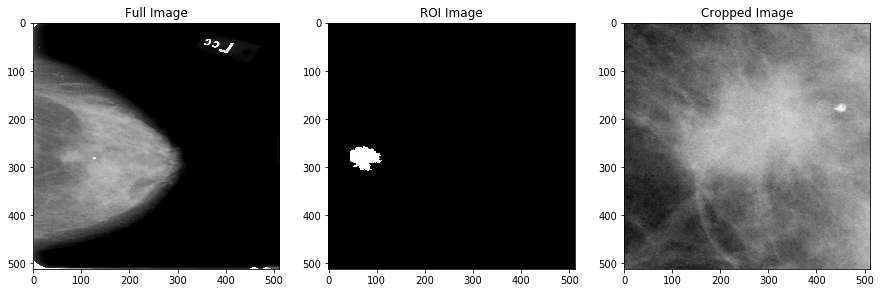

In [45]:
from PIL import Image
im_crop = Image.open('../clean_data/mass/train/crops/0.tif')
im_full = Image.open('../clean_data/mass/train/images/images/0.tif')
im_mask = Image.open('../clean_data/mass/train/masks/masks/0.tif')
imarray_crop = np.array(im_crop)
imarray_full = np.array(im_full)
imarray_mask = np.array(im_mask)
fig, ax = plt.subplots(1, 3, figsize=(15,15))
ax[0].imshow(imarray_full, cmap = 'gray')
ax[0].set_title('Full Image')
ax[1].imshow(imarray_mask, cmap = 'gray')
ax[1].set_title('ROI Image')
ax[2].imshow(imarray_crop, cmap = 'gray')
ax[2].set_title('Cropped Image')
plt.show()
plt.savefig('EDA.png')


# U-Net for mask generation and mass classification on the CBIS-DDSM

In this section, we step through our process for applying a U-Net to the creation of masks on the CBIS-DDSM dataset. The [U-Net](https://arxiv.org/abs/1505.04597) architecture was developed specifically for the task of biomedical image segmentation. Since this model has previously been widely applied in the area, we chose to leverage a previous implementation listed [here](https://github.com/ZFTurbo/ZF_UNET_224_Pretrained_Model), which placed second in an online datascience competition on [Kaggle](https://www.kaggle.com/c/dstl-satellite-imagery-feature-detection).

This notebook includes two distinct models, both built on this same architecture. First, we show a model for generating segmentation masks to identify mass regions. Next, we take a different approach, aiming to combine the process of segmentation with classification -- using the U-Net to make classification decisions on the input image data.

In [3]:
from keras.callbacks import LambdaCallback
from keras.models import load_model
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns

from unet_extras.zf_unet_224_model import ZF_UNET_224, dice_coef_loss, dice_coef

Using TensorFlow backend.


## Unet for General Mass Detection

### Global Params

In [4]:
DATA_DIR = '../clean_data'
NUM_SAMPLES_TRAIN = 776
TARGET_SIZE = (224, 224)
BATCH_SIZE = 16

### Data Prep

In [5]:
# set parameters for image preprocessing and augmentation
data_gen_args = dict(
    rotation_range=45.,
    width_shift_range=0.1,
    height_shift_range=0.1,
    fill_mode='constant',
    validation_split=.2,
    rescale=1./255
)

image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**data_gen_args)

# Provide the same seed and keyword arguments to the fit and flow methods
seed = 1

image_train_generator = image_datagen.flow_from_directory(
    f'{DATA_DIR}/mass/train/images',
    class_mode=None,
    seed=seed,
    subset='training',
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
)

image_val_generator = image_datagen.flow_from_directory(
    f'{DATA_DIR}/mass/train/images',
    class_mode=None,
    seed=seed,
    subset='validation',
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
)

mask_train_generator = mask_datagen.flow_from_directory(
    f'{DATA_DIR}/mass/train/masks',
    class_mode=None,
    seed=seed,
    subset='training',
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    color_mode='grayscale'
)

mask_val_generator = mask_datagen.flow_from_directory(
    f'{DATA_DIR}/mass/train/masks',
    class_mode=None,
    seed=seed,
    subset='validation',
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    color_mode='grayscale'
)

# combine generators into one which yields image and masks
train_generator = zip(image_train_generator, mask_train_generator)
val_generator = zip(image_val_generator, mask_val_generator)

Found 621 images belonging to 1 classes.
Found 155 images belonging to 1 classes.
Found 621 images belonging to 1 classes.
Found 155 images belonging to 1 classes.


### Model building and training

In [6]:
# build the model
model = ZF_UNET_224(weights='generator')
model.compile(
    optimizer=Adam(), 
    loss=dice_coef_loss, 
    metrics=[dice_coef]
)

In [7]:
def callback_plot(epoch, logs):
    """Plots predictions on the validation set in real time during training.
    """
    pred_im, pred_mask = next(val_generator)
    
    preds = model.predict(pred_im)
    
    fig_im, ax_im = plt.subplots(1, 4, figsize=[8, 3])
    fig_mask, ax_mask = plt.subplots(1, 4, figsize=[8, 3])
    fig_pred, ax_pred = plt.subplots(1, 4, figsize=[8, 3])

    for i in range(4):
        ax_im[i].imshow(pred_im[i])
        ax_mask[i].imshow(pred_mask[i].reshape(224, 224), cmap='gray')
        ax_pred[i].imshow(preds[i].reshape(224, 224), cmap='gray')
        
    fig_im.suptitle('Original images')
    fig_mask.suptitle('Ground truth mask')
    fig_pred.suptitle('Predicted Mask')
    
    fig_im.tight_layout()
    fig_mask.tight_layout()
    fig_pred.tight_layout()

    plt.show()

Below, we can see the fitting process of the model. We plot at each step, examples of original images, the ground truth masks, and the predicted masks from the generator. This helped significantly in the training process.

Epoch 1/20
300/300 [==============================] - 235s 785ms/step - loss: -0.2567 - dice_coef: 0.2567


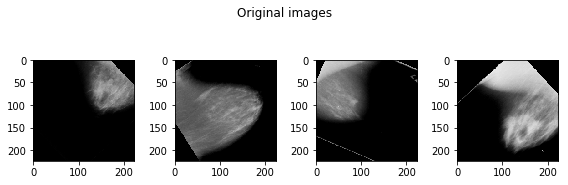

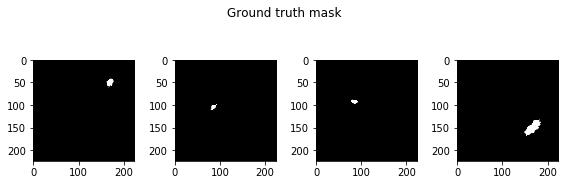

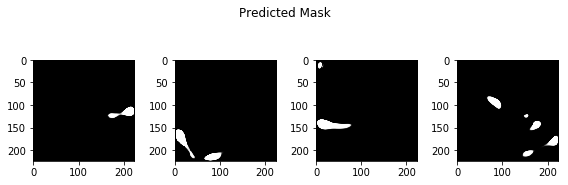

Epoch 2/20
300/300 [==============================] - 218s 727ms/step - loss: -0.3384 - dice_coef: 0.3384


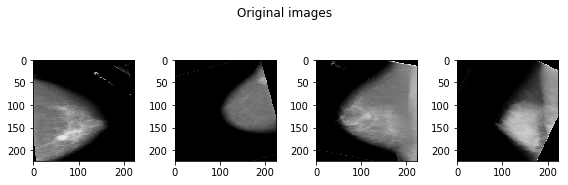

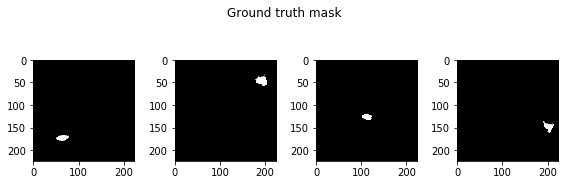

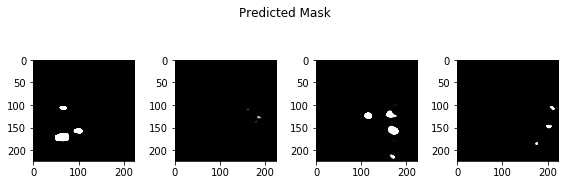

Epoch 3/20
300/300 [==============================] - 218s 727ms/step - loss: -0.3597 - dice_coef: 0.3597


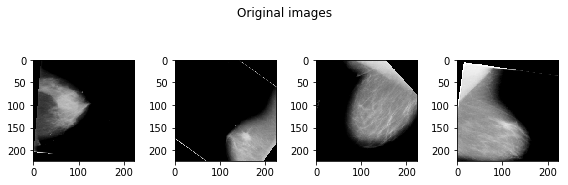

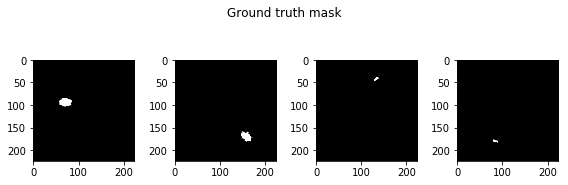

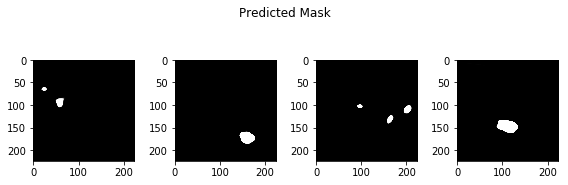

Epoch 4/20
300/300 [==============================] - 218s 728ms/step - loss: -0.3860 - dice_coef: 0.3860


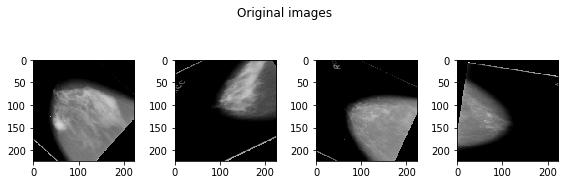

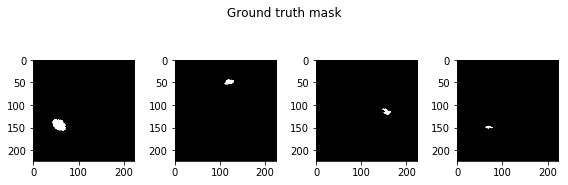

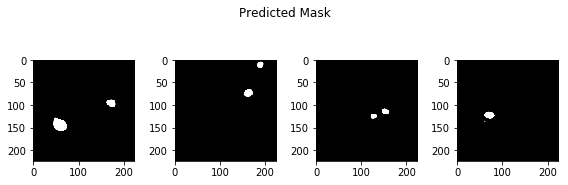

Epoch 5/20
300/300 [==============================] - 219s 729ms/step - loss: -0.3960 - dice_coef: 0.3960


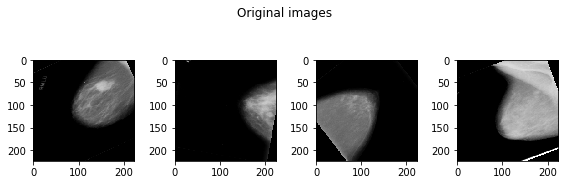

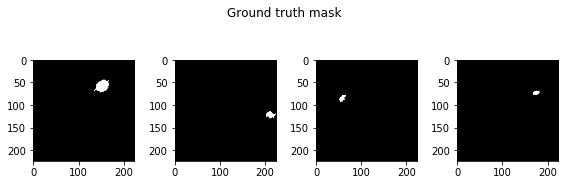

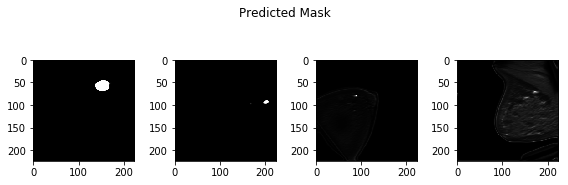

Epoch 6/20
300/300 [==============================] - 218s 727ms/step - loss: -0.4198 - dice_coef: 0.4198


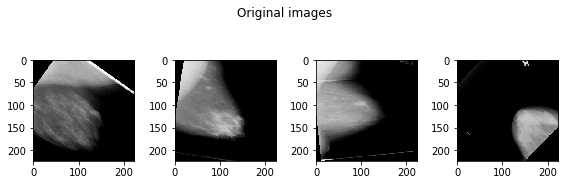

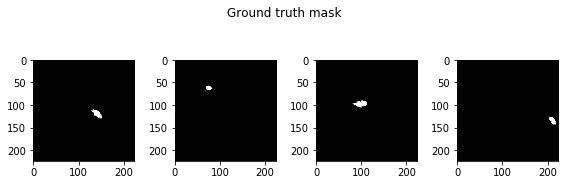

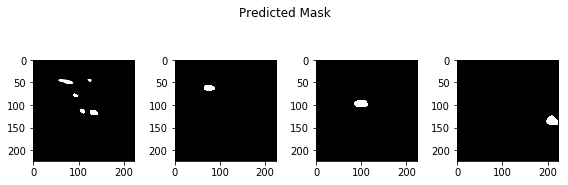

Epoch 7/20
300/300 [==============================] - 219s 728ms/step - loss: -0.4195 - dice_coef: 0.4195


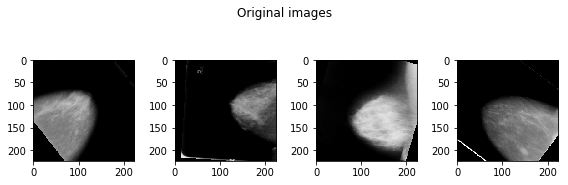

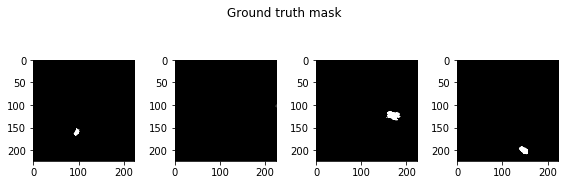

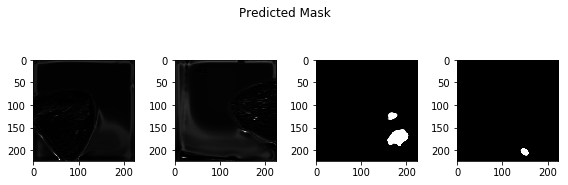

Epoch 8/20
300/300 [==============================] - 218s 728ms/step - loss: -0.4366 - dice_coef: 0.4366


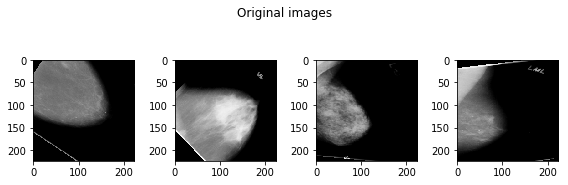

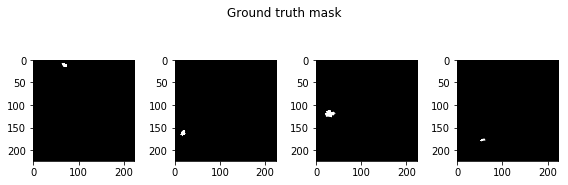

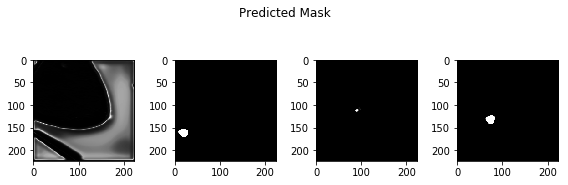

Epoch 9/20
300/300 [==============================] - 219s 729ms/step - loss: -0.4358 - dice_coef: 0.4358


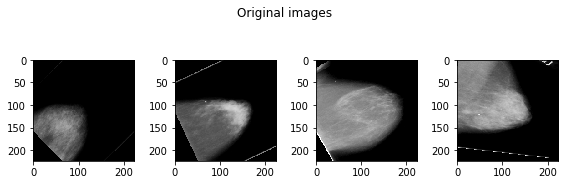

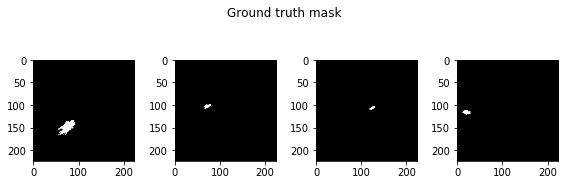

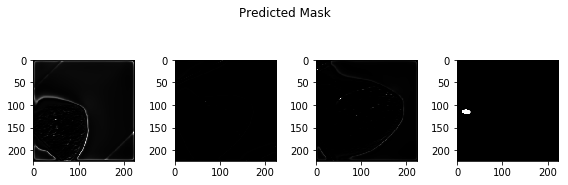

Epoch 10/20
300/300 [==============================] - 218s 728ms/step - loss: -0.4622 - dice_coef: 0.4622


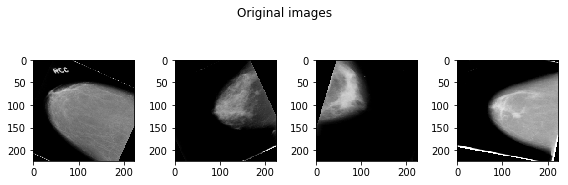

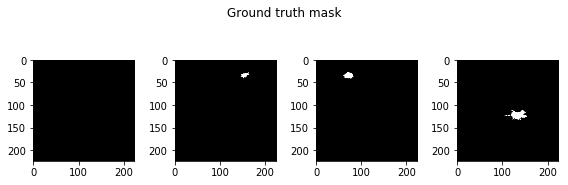

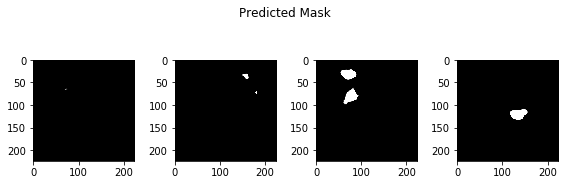

Epoch 11/20
300/300 [==============================] - 219s 729ms/step - loss: -0.4556 - dice_coef: 0.4556


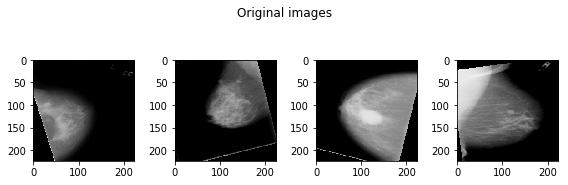

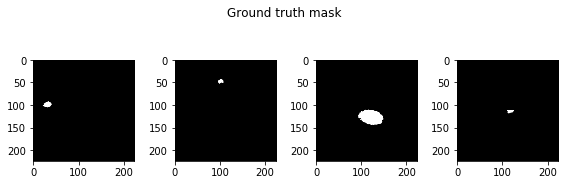

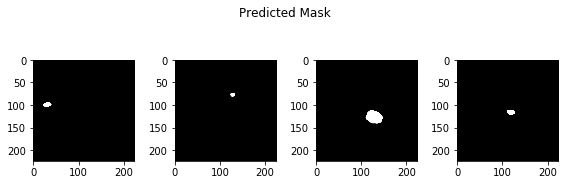

Epoch 12/20
300/300 [==============================] - 218s 727ms/step - loss: -0.4754 - dice_coef: 0.4754


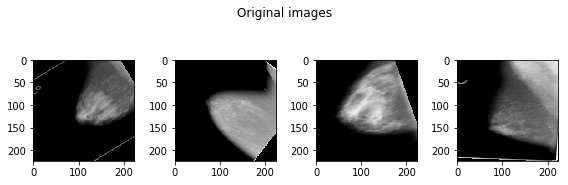

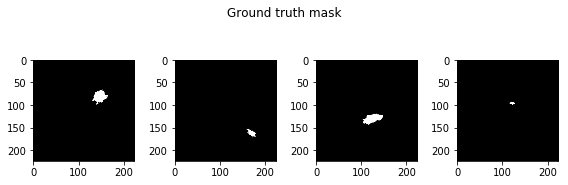

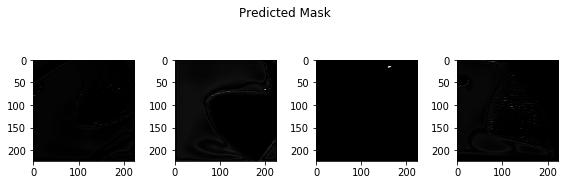

Epoch 13/20
300/300 [==============================] - 219s 728ms/step - loss: -0.4774 - dice_coef: 0.4774


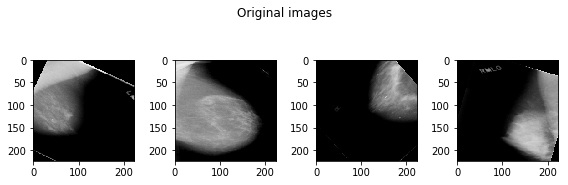

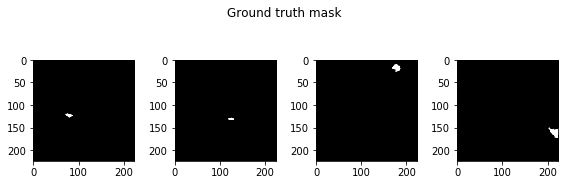

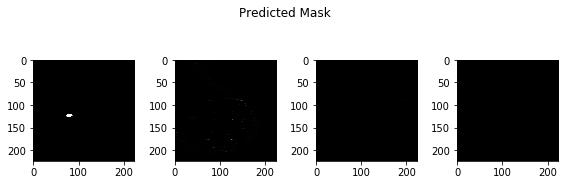

Epoch 14/20
300/300 [==============================] - 219s 729ms/step - loss: -0.4749 - dice_coef: 0.4749


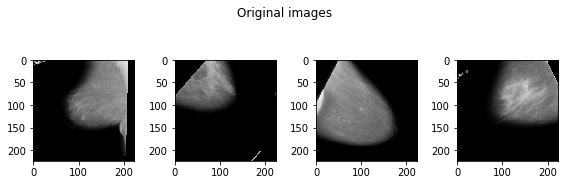

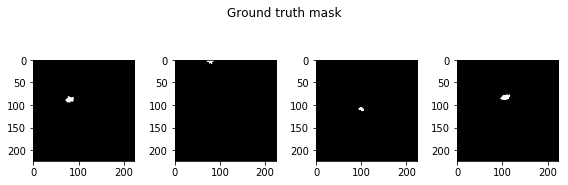

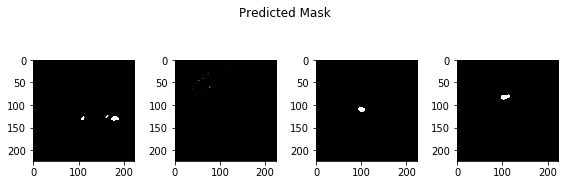

Epoch 15/20
300/300 [==============================] - 218s 728ms/step - loss: -0.4939 - dice_coef: 0.4939


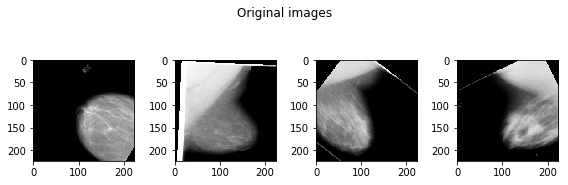

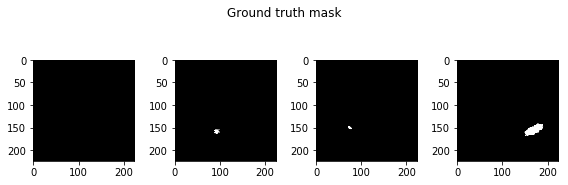

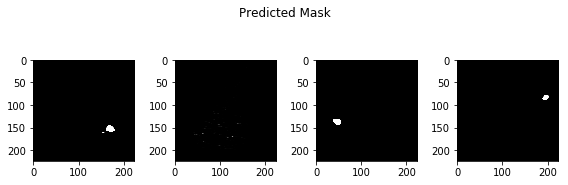

Epoch 16/20
300/300 [==============================] - 218s 727ms/step - loss: -0.5034 - dice_coef: 0.5034


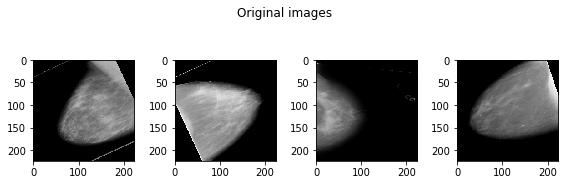

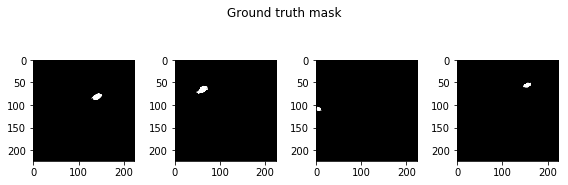

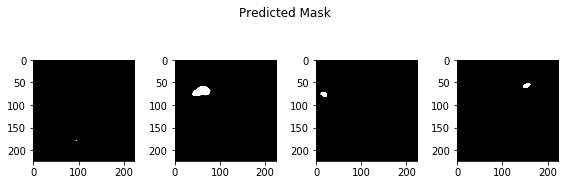

Epoch 17/20
300/300 [==============================] - 218s 728ms/step - loss: -0.5213 - dice_coef: 0.5213


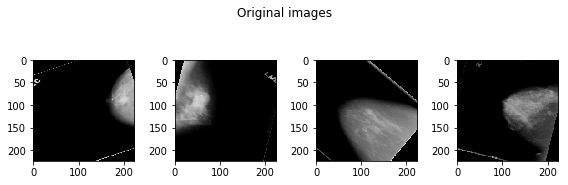

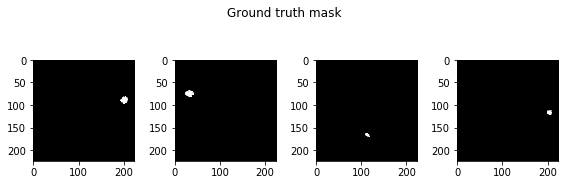

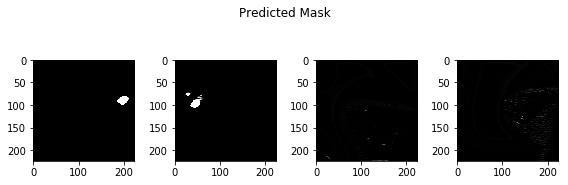

Epoch 18/20
300/300 [==============================] - 218s 727ms/step - loss: -0.5184 - dice_coef: 0.5184


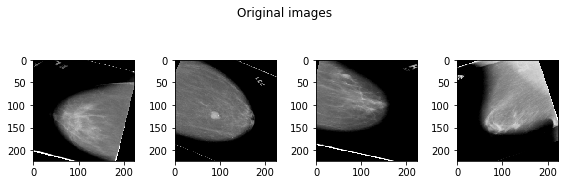

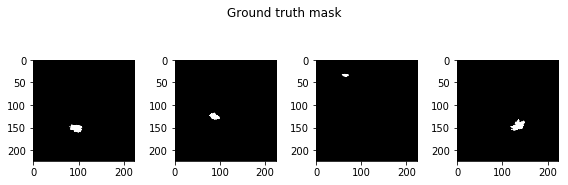

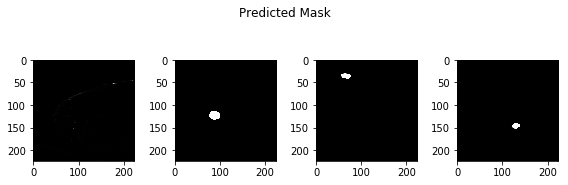

Epoch 19/20
300/300 [==============================] - 218s 727ms/step - loss: -0.5262 - dice_coef: 0.5262


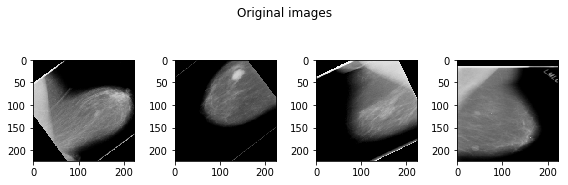

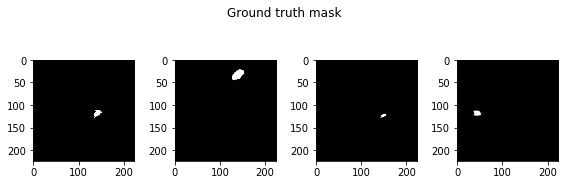

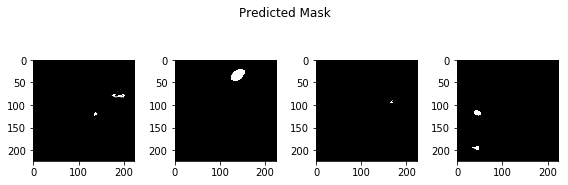

Epoch 20/20
300/300 [==============================] - 218s 728ms/step - loss: -0.5368 - dice_coef: 0.5368


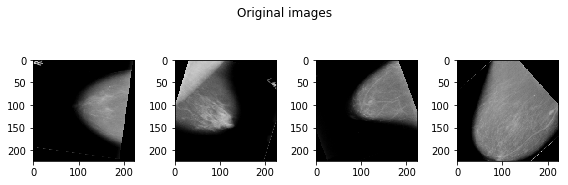

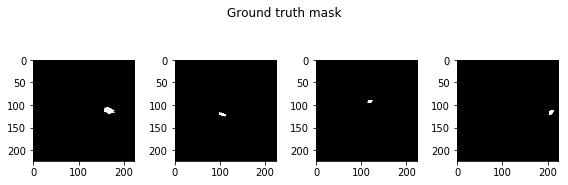

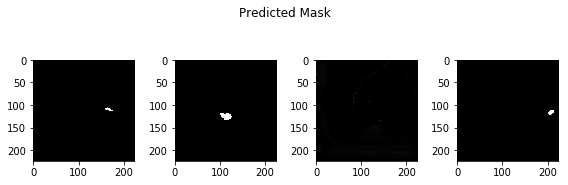

In [8]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch=300,
    epochs=20,
    callbacks=[LambdaCallback(on_epoch_end=callback_plot)]
)

In [9]:
model.save('unet_full.h5')

### Set up test data

In [10]:
data_generator_image_test = ImageDataGenerator(rescale=1./255)
data_generator_mask_test = ImageDataGenerator(rescale=1./255)

image_test_generator = data_generator_image_test.flow_from_directory(
    f'{DATA_DIR}/mass/test/images',
    class_mode=None,
    seed=seed,
    target_size=TARGET_SIZE,
    color_mode='rgb'
)

mask_test_generator = data_generator_mask_test.flow_from_directory(
    f'{DATA_DIR}/mass/test/masks',
    class_mode=None,
    seed=seed,
    target_size=TARGET_SIZE
)

test_generator = zip(image_test_generator, mask_test_generator)

Found 275 images belonging to 1 classes.
Found 275 images belonging to 1 classes.


In [11]:
# get batch of test images for plotting
im, mask = next(test_generator)

pred = model.predict(im, steps=len(im), verbose = 1)

32/32 [==============================] - 17s 536ms/step


In [12]:
def show_predictions(ims, masks, preds, index=0):
    """Plot an array of three images showing the original image, ground truth mask, and predicted mask.
    """
    fig, ax = plt.subplots(1, 3, figsize=[8, 4])
    
    ax[0].imshow(ims[index])
    ax[1].imshow(masks[index])
    ax[2].imshow(preds[index].reshape(224, 224), cmap='gray')

    ax[0].set_title('Original image')
    ax[1].set_title('True mask')
    ax[2].set_title('Predicted mask')

### Evaluating Results

To examine the results, we will take a qualitative look at examples from the test set. We can see that the model performed fairly well overall in matching the expected masks. In some cases, the model was unable to spot the mass, and in others, it spotted areas taht were not actually masses. However, overall, we see that the model tended to predict the correct area as well as general shape of the masses.

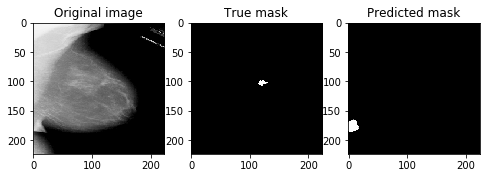

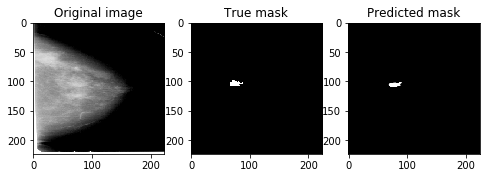

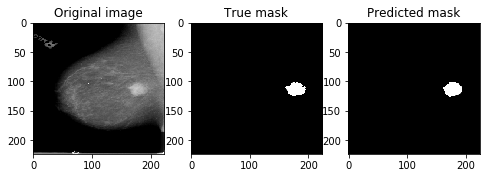

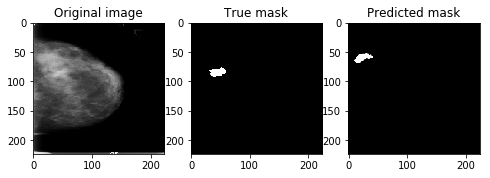

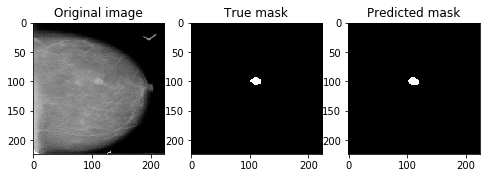

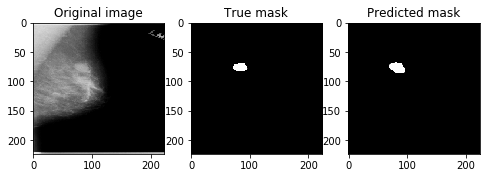

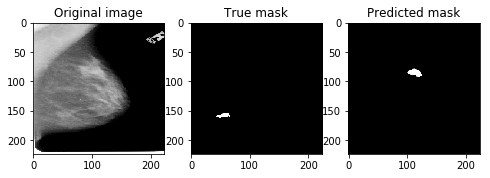

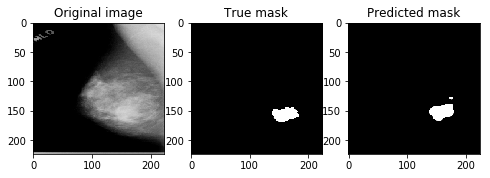

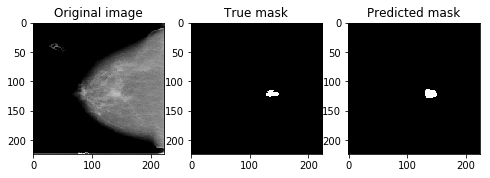

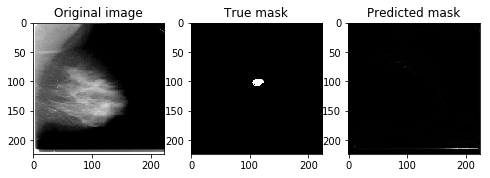

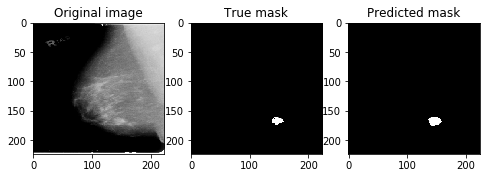

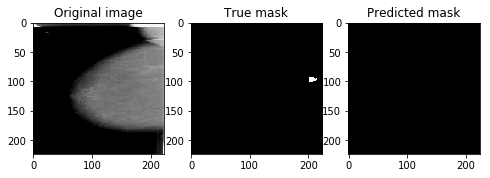

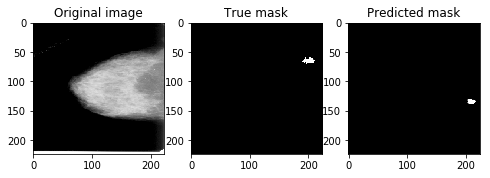

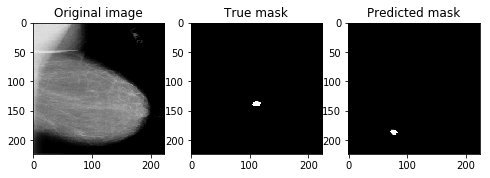

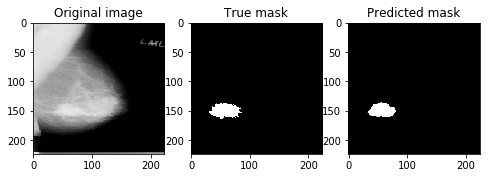

In [13]:
for i in range(15):
    show_predictions(im, mask, pred, index=i)

# Unet for Malignant Mass Detection ("Blackbox Method")

In this case, we want our UNET to only give masks for malignant masses. To do this, we will train using all black masks for benign samples and normal masks for malignant ones.

## Data Prep

We will do most of the same dataprep as above.

In [14]:
# recreate our generators to ensure seed hasn't changed (using same args from above)
image_bb_datagen = ImageDataGenerator(**data_gen_args)
mask_bb_datagen = ImageDataGenerator(**data_gen_args)

# use the same seed for masks and images throughout so they line up correctly
seed = 1

image_bb_train_generator = image_bb_datagen.flow_from_directory(
    f'{DATA_DIR}/mass/train/images',
    class_mode=None,
    seed=seed,
    subset='training',
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
)

image_bb_val_generator = image_datagen.flow_from_directory(
    f'{DATA_DIR}/mass/train/images',
    class_mode=None,
    seed=seed,
    subset='validation',
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
)

mask_bb_train_generator = mask_bb_datagen.flow_from_directory(
    f'{DATA_DIR}/mass/train/mask_blackbox',
    class_mode=None,
    seed=seed,
    subset='training',
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    color_mode='grayscale'
)

mask_bb_val_generator = mask_bb_datagen.flow_from_directory(
    f'{DATA_DIR}/mass/train/mask_blackbox',
    class_mode=None,
    seed=seed,
    subset='validation',
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    color_mode='grayscale'
)

# combine generators into one which yields image and masks
train_bb_generator = zip(image_bb_train_generator, mask_bb_train_generator)
val_bb_generator = zip(image_bb_val_generator, mask_bb_val_generator)

Found 621 images belonging to 1 classes.
Found 155 images belonging to 1 classes.
Found 621 images belonging to 1 classes.
Found 155 images belonging to 1 classes.


### Recompile and Fit Model

In [15]:
def callback_bb_plot(_epochs, _log):
    """Plot images from the validation bb_generator while training.
    """
    pred_im, pred_mask = next(val_bb_generator)

    preds = model.predict(pred_im)

    fig_im, ax_im = plt.subplots(1, 4, figsize=[8, 3])
    fig_mask, ax_mask = plt.subplots(1, 4, figsize=[8, 3])
    fig_pred, ax_pred = plt.subplots(1, 4, figsize=[8, 3])

    for i in range(4):
        ax_im[i].imshow(pred_im[i])
        ax_mask[i].imshow(pred_mask[i].reshape(224, 224), cmap='gray')
        ax_pred[i].imshow(preds[i].reshape(224, 224), cmap='gray')

    fig_im.suptitle('Original images')
    fig_mask.suptitle('Ground truth mask')
    fig_pred.suptitle('Predicted Mask')

    fig_im.tight_layout()
    fig_mask.tight_layout()
    fig_pred.tight_layout()

    plt.show()

For this part, we load the weights from our previous model. We chose to use this as a starting point, since the model already knows how to spot masses. Now, we will try to build on that to learn how to spot specifically malignant masses.

In [16]:
model_bb = load_model(
    'unet_full.h5',
    custom_objects={
        'dice_coef': dice_coef,
        'dice_coef_loss': dice_coef_loss,
    }
)

Epoch 1/20
300/300 [==============================] - 225s 751ms/step - loss: -0.4781 - dice_coef: 0.4781


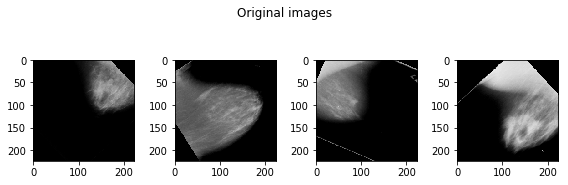

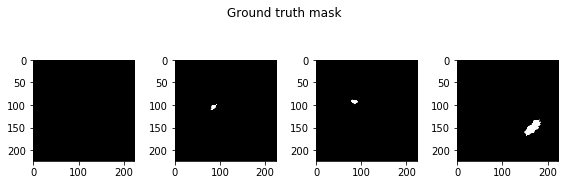

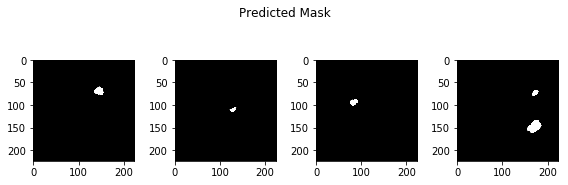

Epoch 2/20
300/300 [==============================] - 219s 729ms/step - loss: -0.5003 - dice_coef: 0.5003


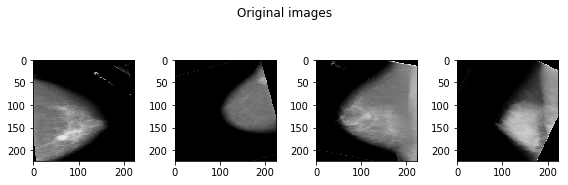

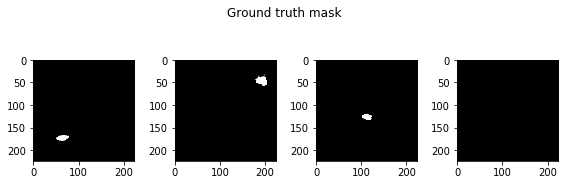

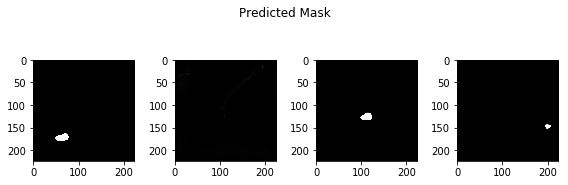

Epoch 3/20
300/300 [==============================] - 218s 728ms/step - loss: -0.4828 - dice_coef: 0.4828


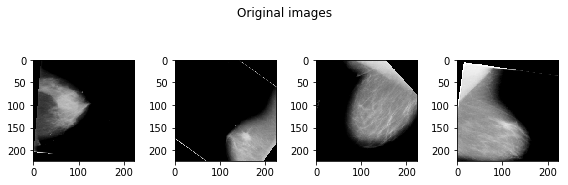

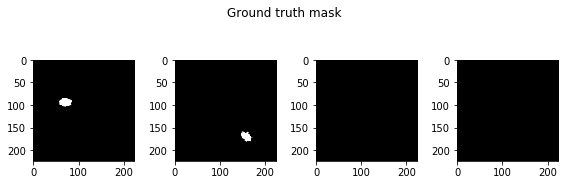

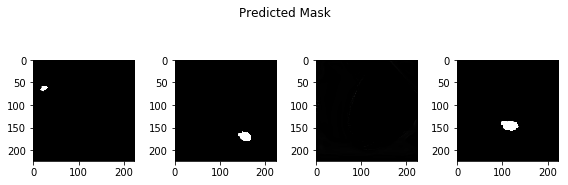

Epoch 4/20
300/300 [==============================] - 219s 730ms/step - loss: -0.4939 - dice_coef: 0.4939


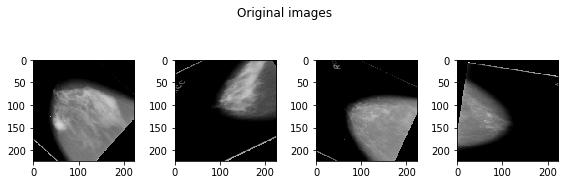

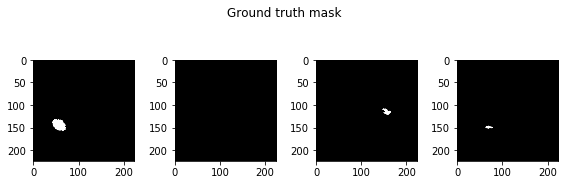

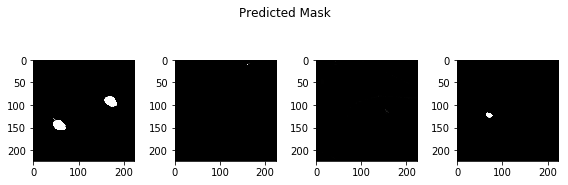

Epoch 5/20
300/300 [==============================] - 218s 728ms/step - loss: -0.5420 - dice_coef: 0.5420


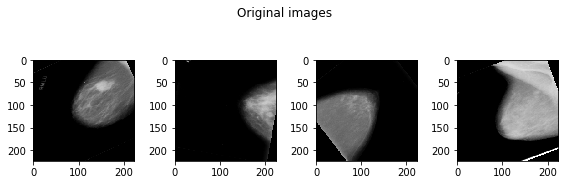

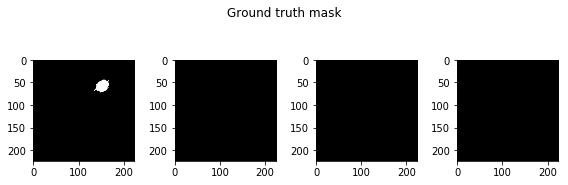

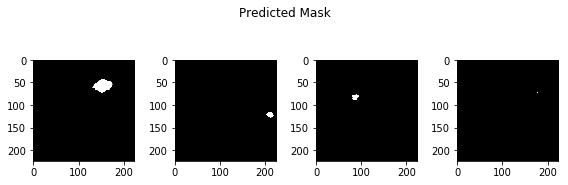

Epoch 6/20
300/300 [==============================] - 219s 729ms/step - loss: -0.5421 - dice_coef: 0.5421


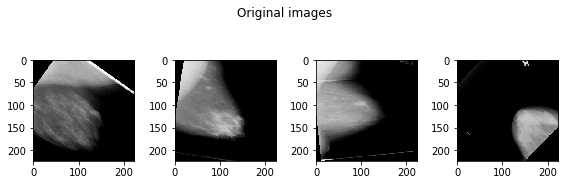

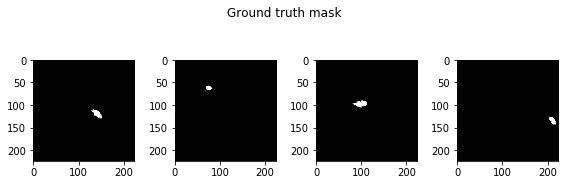

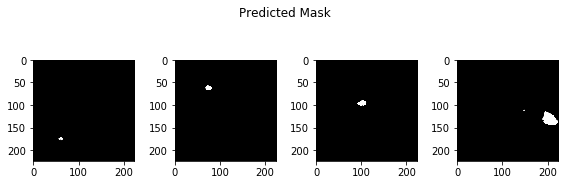

Epoch 7/20
300/300 [==============================] - 218s 728ms/step - loss: -0.5581 - dice_coef: 0.5581


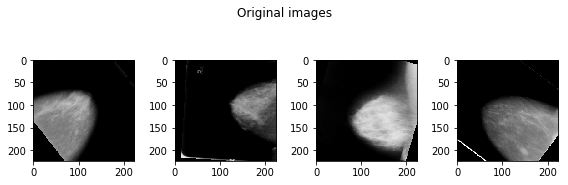

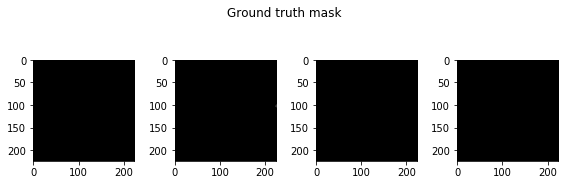

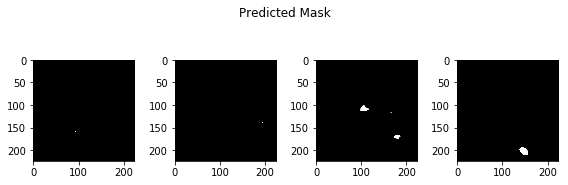

Epoch 8/20
300/300 [==============================] - 219s 729ms/step - loss: -0.5522 - dice_coef: 0.5522


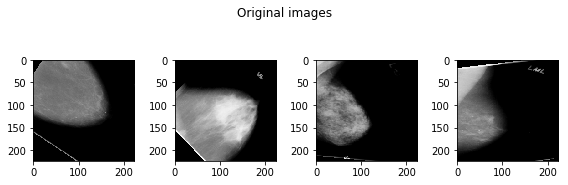

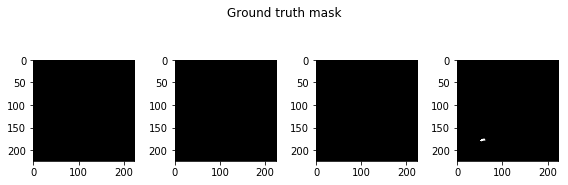

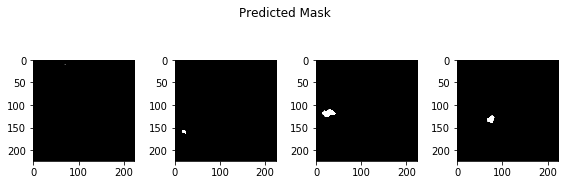

Epoch 9/20
300/300 [==============================] - 219s 729ms/step - loss: -0.5504 - dice_coef: 0.5504


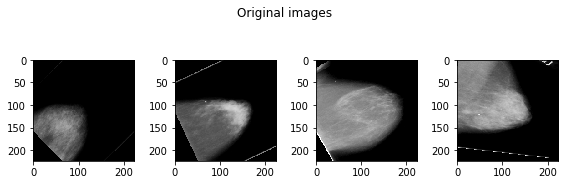

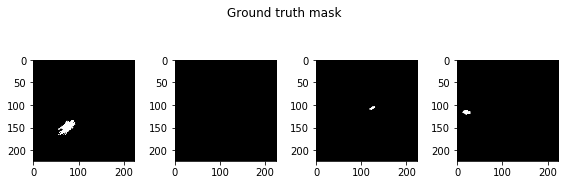

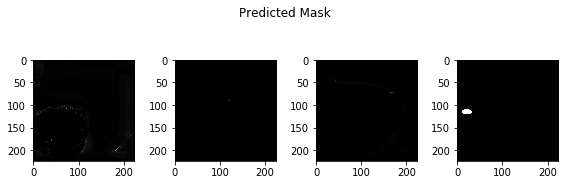

Epoch 10/20
300/300 [==============================] - 218s 728ms/step - loss: -0.5698 - dice_coef: 0.5698


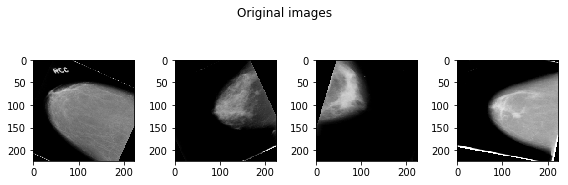

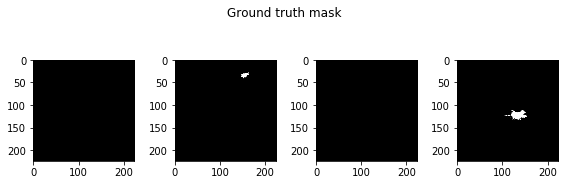

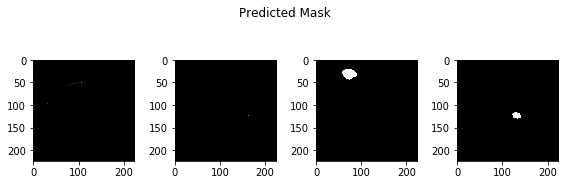

Epoch 11/20
300/300 [==============================] - 219s 729ms/step - loss: -0.5699 - dice_coef: 0.5699


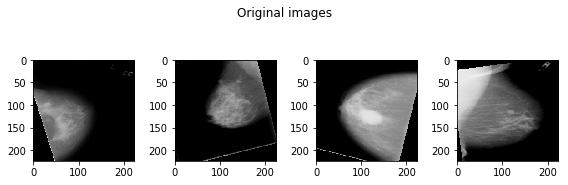

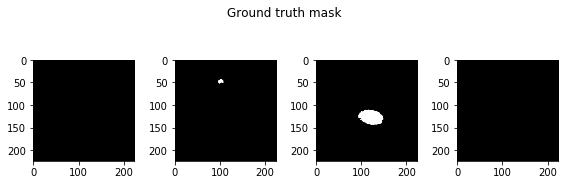

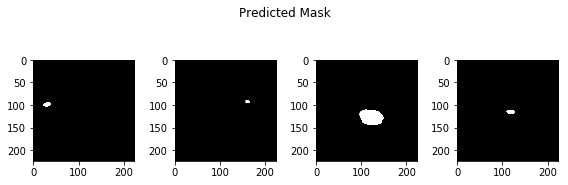

Epoch 12/20
300/300 [==============================] - 218s 727ms/step - loss: -0.5583 - dice_coef: 0.5583


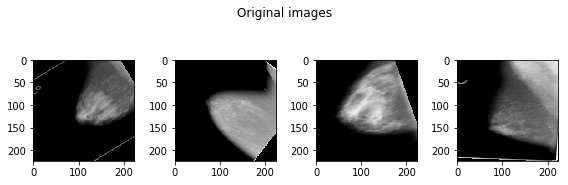

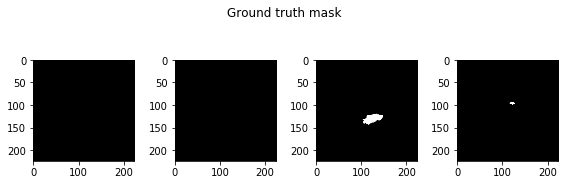

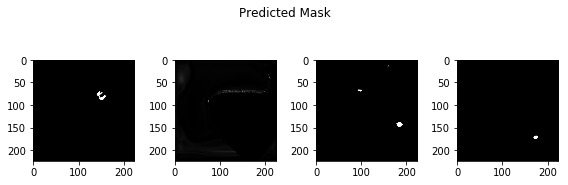

Epoch 13/20
300/300 [==============================] - 219s 729ms/step - loss: -0.5577 - dice_coef: 0.5577


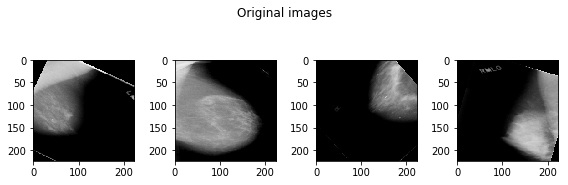

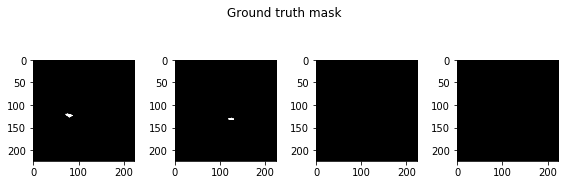

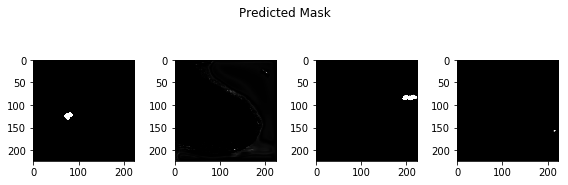

Epoch 14/20
300/300 [==============================] - 219s 730ms/step - loss: -0.5970 - dice_coef: 0.5970


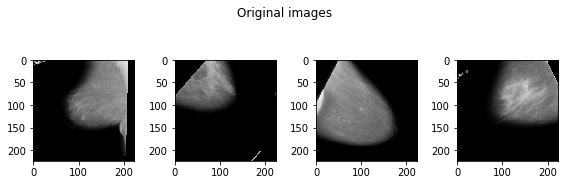

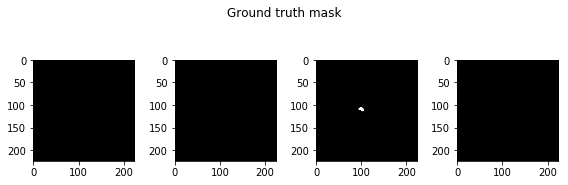

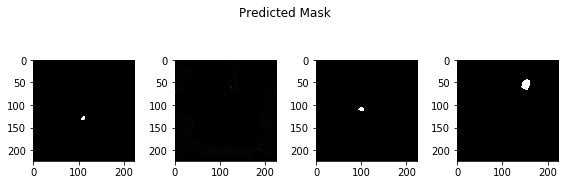

Epoch 15/20
300/300 [==============================] - 219s 729ms/step - loss: -0.6073 - dice_coef: 0.6073


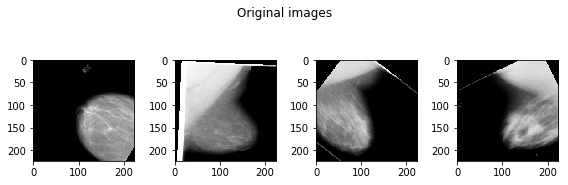

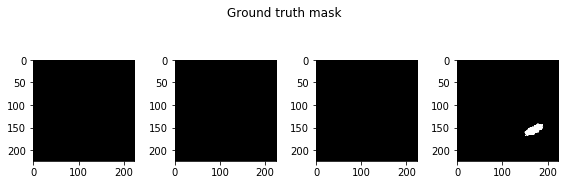

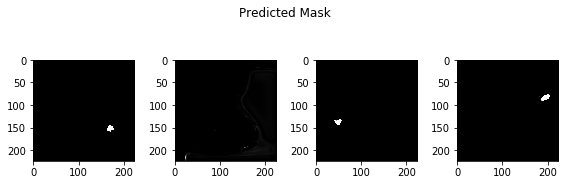

Epoch 16/20
300/300 [==============================] - 218s 727ms/step - loss: -0.5963 - dice_coef: 0.5963


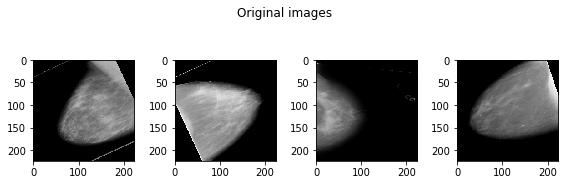

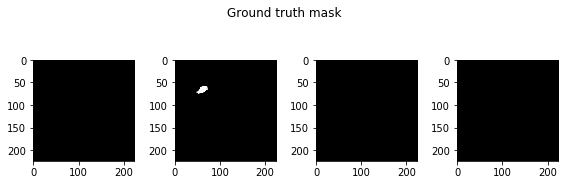

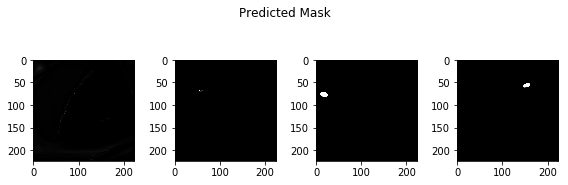

Epoch 17/20
300/300 [==============================] - 219s 729ms/step - loss: -0.6038 - dice_coef: 0.6038


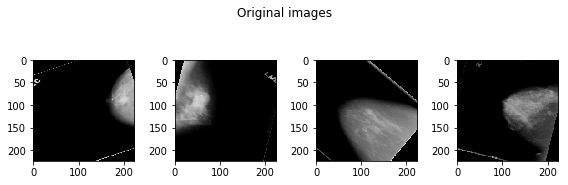

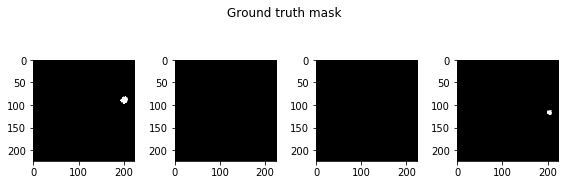

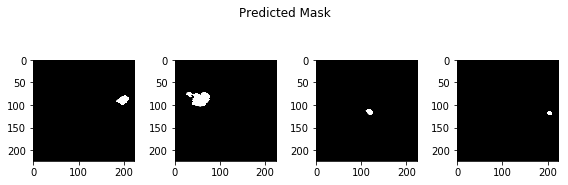

Epoch 18/20
300/300 [==============================] - 219s 729ms/step - loss: -0.6191 - dice_coef: 0.6191


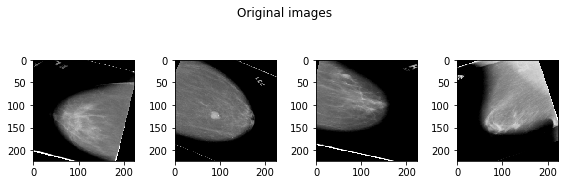

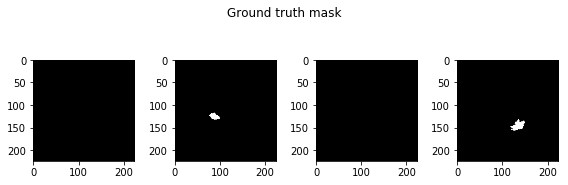

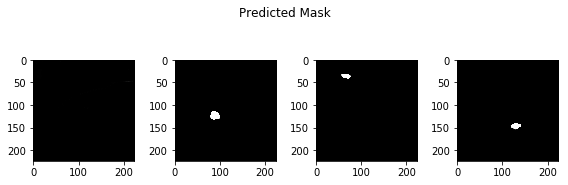

Epoch 19/20
300/300 [==============================] - 218s 727ms/step - loss: -0.5744 - dice_coef: 0.5744


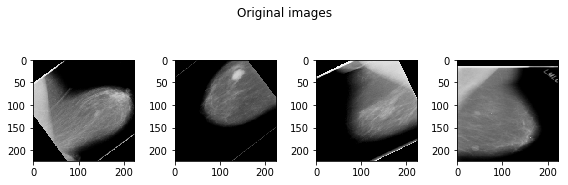

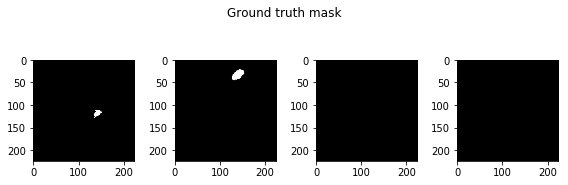

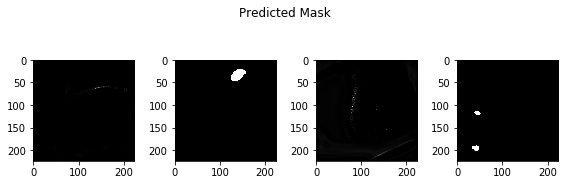

Epoch 20/20
300/300 [==============================] - 219s 729ms/step - loss: -0.5859 - dice_coef: 0.5859


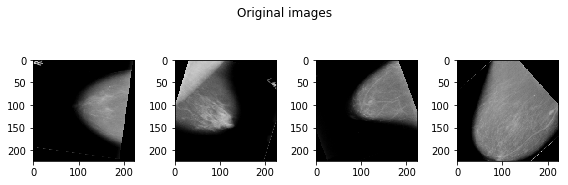

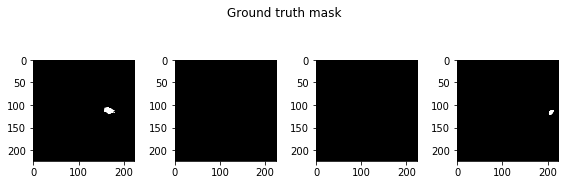

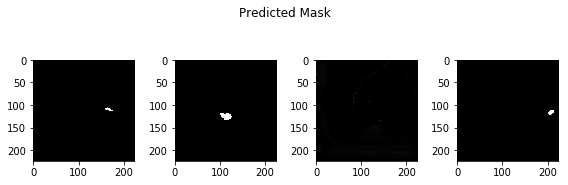

In [17]:
model_bb.compile(optimizer=Adam(), loss=dice_coef_loss, metrics=[dice_coef])

history = model_bb.fit_generator(
    train_bb_generator,
    steps_per_epoch=300,
    epochs=20,
    callbacks=[LambdaCallback(on_epoch_end=callback_bb_plot)]
)

In [18]:
model_bb.save('unet_bb.h5')

### Set up testing data

In [19]:
N_TEST_SAMPLES = 275

In [20]:
# again need to recreate to ensure correct alignment
data_generator_image_bb_test = ImageDataGenerator(rescale=1./255)
data_generator_mask_bb_test = ImageDataGenerator(rescale=1./255)

image_bb_test_generator = data_generator_image_bb_test.flow_from_directory(
    f'{DATA_DIR}/mass/test/images',
    class_mode=None,
    seed=seed,
    target_size=TARGET_SIZE,
    color_mode='rgb',
    batch_size=N_TEST_SAMPLES,
)

mask_bb_test_generator = data_generator_mask_bb_test.flow_from_directory(
    f'{DATA_DIR}/mass/test/mask_blackbox',
    class_mode=None,
    seed=seed,
    target_size=TARGET_SIZE,
    batch_size=N_TEST_SAMPLES,
)

test_bb_generator = zip(image_bb_test_generator, mask_bb_test_generator)

Found 275 images belonging to 1 classes.
Found 275 images belonging to 1 classes.


In [21]:
im_bb, mask_bb = next(test_bb_generator)

pred_bb = model_bb.predict(im_bb)

### Evaluating results

First, we will take a qualitative look at the results on the test set, as we did before with the previous model.

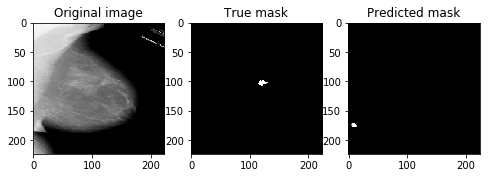

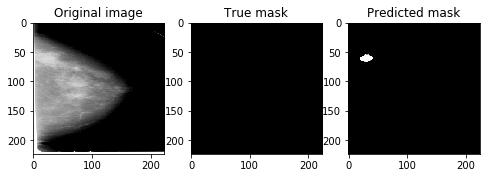

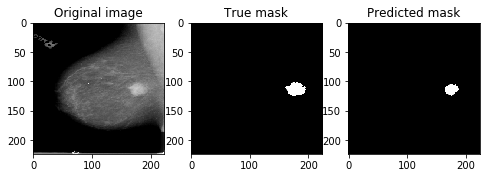

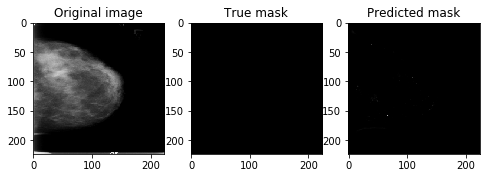

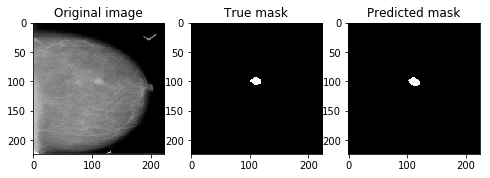

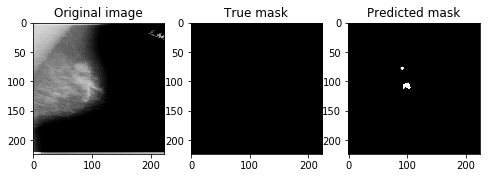

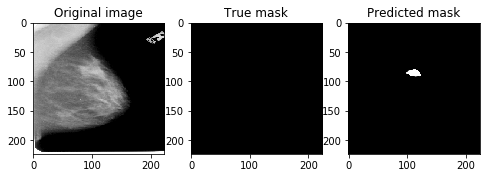

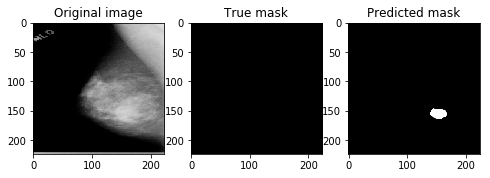

In [22]:
for i in range(8):
    show_predictions(im_bb, mask_bb, pred_bb, index=i)

We can see that our model seems to have begun to learn to classify malignant from benign masses. In some of the images, we see all black or nearly all black masks on benign masses. However, we do see some cases where the model predicts a full mass on benign samples, as in the final two test cases.

### From masks to classification

Now, we will try to extrapolate our masks to actually make Malignant/Benign classifications on the mass imgages. To do this, we will assume that our model has learned to return all black images in benign cases. So, we will make predictions in a very simple manner -- if there are any white pixels (or more than some low threshold level), we will classify as malignant and benign otherwise.

In [23]:
def is_benign(mask, threshold=0):
    """Returns bool determined by sum of values of all pixels.
    """
    return np.sum(mask) > threshold

In [68]:
# collect classificaion values from output masks
y_predict = []
y_test = []
y_predict_vals = []

for i in range(len(mask_bb)):
    y_test.append(is_benign(mask_bb[i]))
    y_predict.append(is_benign(pred_bb[i], threshold=.0001))
    y_predict_vals.append(np.sum(pred_bb[i]))

We chose a threshold of 20, as this seemed to capture the cutoff between diagnositic boundaries. Below, we can see a distribution of the pixel sums, validating this choice. Note that the adjacent bin was empty, meaning there would have been no effect in moving the threshold slightly higher or lower.

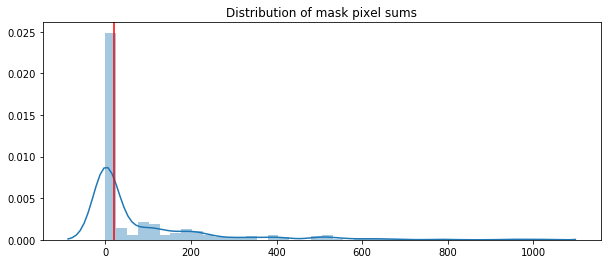

In [69]:
fig, ax = plt.subplots(figsize=[10, 4])
sns.distplot(y_predict_vals, bins=40, ax=ax)
ax.axvline(20, c='r')
ax.set_title('Distribution of mask pixel sums');

In [70]:
print(f'Accuracy of "Blackbox" method on test set: {accuracy_score(y_test, y_predict)}')

Accuracy of "Blackbox" method on test set: 0.5818181818181818


In [71]:
print('Confusion matrix on test set:')
display(pd.DataFrame(confusion_matrix(y_test, y_predict), ))

Confusion matrix on test set:


,0,1
0,101,66
1,49,59


### Discussion on Classification U-Net

Our model achieved a 58% classification rate on the test set. In fact, with different threshold values, we found higher classification accuracices (up to 70%). However, since our main goal was to prevent false negatives as often as possible, we chose to use a very low threshold and allow the human interpreter to make a conclusive decision on close cases. We found the potential for this high of an accuracy very surprising, given that this model was not designed for classification and we performed a very simple step to jump to classification. 

# ResNet classification between malignant and benign masses

In [4]:
# import necessary packages
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dense
from keras.applications import ResNet50
from keras.applications.resnet50 import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
import sklearn.metrics as sklearn

In [5]:
train = pd.read_csv('../clean_data/mass/train/resnet_train_data.csv')
test = pd.read_csv('../clean_data/mass/test/resnet_test_data.csv')

### Training the ResNet

Here, we start to build the ResNet. Much of this code was inspired by research done in https://www.kaggle.com/suniliitb96/tutorial-keras-transfer-learning-with-resnet50/data. The following cell defines many of the hyper parameters that we will be using for the model, all of which are commonplace when dealing with classification between two classes via ResNet.

In [6]:
# number of classes to represent benign vs malignant tumors
NUM_CLASSES = 2

CHANNELS = 3

# it's standard practice to use an image size of 224x224 when dealing with images in the
# CBIS-DDSM dataset
IMAGE_RESIZE = 224

# it is standard practice to use binary crossentropy when dealing with classifying two classes
OBJECTIVE_FUNCTION = 'binary_crossentropy'

# use a softmax dense layer activation and pooling average of avg
RESNET50_POOLING_AVERAGE = 'avg'
DENSE_LAYER_ACTIVATION = 'softmax'

LOSS_METRICS = ['accuracy']

# train for 100 epochs. Could increase this but saw reasonable results after 75 epochs.
NUM_EPOCHS = 100

# set these as none so that they are auto filled
STEPS_PER_EPOCH_TRAINING = None
STEPS_PER_EPOCH_VALIDATION = None

# using batch sizes of 16
BATCH_SIZE_TRAINING = 16
BATCH_SIZE_VALIDATION = 16

# only need one to easily map between test generator and prediction
BATCH_SIZE_TESTING = 1

We can use pre-trained weights from other models, then train those weights using our data to achieve more accurate results. These weights come from the same source, https://www.kaggle.com/suniliitb96/tutorial-keras-transfer-learning-with-resnet50/data, mentioned earlier. This processs is called "transfer learning" and it is often utilized for its speed and effectiveness. Here, we transfer the knowledge of one model designed for a different task to handle the task that we have given it: classifying images between benign and malignant masses. Another benefit of using a model that is pre-trained on other images is that it has a large database of images that it is previously trained on, which means that we do not have to train it on as many new images and can rely on a smaller subset of images to train, as is the case here.

In [7]:
resnet_weights_path = 'resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'

In [8]:
# build the model using the previous weights
model = Sequential()

# we're not including the fully connected layer at the top
model.add(ResNet50(include_top = False, pooling = RESNET50_POOLING_AVERAGE, weights = resnet_weights_path))

# here, use the dense layer for classification between benign and malignant tumors
model.add(Dense(NUM_CLASSES, activation = DENSE_LAYER_ACTIVATION))

# resnet layer is already trained, no need to train it further
model.layers[0].trainable = False

Below is the summary of the model, reflecting that we have 4,098 trainable parameters and over 23 million parameters that we have already trained.

In [9]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 2048)              23587712  
_________________________________________________________________
dense (Dense)                (None, 2)                 4098      
Total params: 23,591,810
Trainable params: 4,098
Non-trainable params: 23,587,712
_________________________________________________________________


Below, after attempting to compile the model using adam as our optimizer, we found that the SGD actually made for a better optimizer in that we had more control over its parameters. After much tuning to get the lowest number of false negatives possible, we arrived at the following combination of parameters. We tune for the false negative rate because it is catastrophic to say that one person does not have cancer when they actually do, while it is not the end of the world to tell them that they do have cancer when they do not, because then they just go in for extra screenings and realize that they have a clean bill of health.

In [10]:
# compile the model using SGD as the optimizer
sgd = optimizers.SGD(lr = 0.01, decay = 1e-6, momentum = 0.9, nesterov = True)
model.compile(optimizer = sgd, loss = OBJECTIVE_FUNCTION, metrics = LOSS_METRICS)

Now that the model is built, we generate the data, splitting it into a training and validation set in order to track the model's performance on data that it has never seen. We will use the batch size and image size that we predetermined when starting to build this model.

In [11]:
image_size = IMAGE_RESIZE
data_generator = ImageDataGenerator(preprocessing_function=preprocess_input, validation_split=0.2)

train_generator = data_generator.flow_from_dataframe(train,
                                                     directory = '../clean_data/mass/train/crops/',
                                                     x_col = 'path',
                                                     y_col = 'class',
                                                     target_size= (image_size, image_size),
                                                     batch_size = BATCH_SIZE_TRAINING,
                                                     class_mode = 'categorical',
                                                     subset = 'training')

validation_generator = data_generator.flow_from_dataframe(train,
                                                          directory = '../clean_data/mass/train/crops/',
                                                          x_col = 'path',
                                                          y_col = 'class',
                                                          target_size= (image_size, image_size),
                                                          batch_size = BATCH_SIZE_TRAINING,
                                                          class_mode = 'categorical',
                                                          subset = 'validation')

Found 621 images belonging to 2 classes.
Found 155 images belonging to 2 classes.


Now fit the generator, again using the hyper parameters described above.

In [12]:
fit_history = model.fit_generator(
        train_generator,
        steps_per_epoch=STEPS_PER_EPOCH_TRAINING,
        epochs = NUM_EPOCHS,
        validation_data=validation_generator,
        validation_steps=STEPS_PER_EPOCH_VALIDATION
)

Epoch 1/100
39/39 [==============================] - 13s 335ms/step - loss: 0.8397 - acc: 0.6080 - val_loss: 2.8120 - val_acc: 0.4774
Epoch 2/100
39/39 [==============================] - 7s 167ms/step - loss: 0.8325 - acc: 0.6588 - val_loss: 1.5817 - val_acc: 0.5032
Epoch 3/100
39/39 [==============================] - 7s 167ms/step - loss: 0.5494 - acc: 0.7492 - val_loss: 1.3968 - val_acc: 0.4968
Epoch 4/100
39/39 [==============================] - 7s 167ms/step - loss: 0.5115 - acc: 0.7758 - val_loss: 1.2844 - val_acc: 0.5806
Epoch 5/100
39/39 [==============================] - 7s 167ms/step - loss: 0.4683 - acc: 0.7902 - val_loss: 1.0316 - val_acc: 0.6000
Epoch 6/100
39/39 [==============================] - 7s 168ms/step - loss: 0.3717 - acc: 0.8442 - val_loss: 1.4717 - val_acc: 0.5806
Epoch 7/100
39/39 [==============================] - 7s 168ms/step - loss: 0.4056 - acc: 0.8125 - val_loss: 1.1377 - val_acc: 0.5613
Epoch 8/100
39/39 [==============================] - 7s 168ms/step -

### Testing the ResNet

Now that the model has been trained on our data to classify between benign and malignant masses, generate the testing data to evaluate the predictive performance of the model.

In [13]:
data_generator_test = ImageDataGenerator(preprocessing_function=preprocess_input)

In [14]:
test_generator = data_generator.flow_from_dataframe(test,
                                                     directory = '../clean_data/mass/test/crops/',
                                                     x_col = 'path',
                                                     y_col = 'class',
                                                     target_size= (image_size, image_size),
                                                     batch_size = BATCH_SIZE_TRAINING,
                                                     class_mode = 'categorical')

Found 238 images belonging to 2 classes.


In [15]:
# reset before each call to predict
test_generator.reset()

# generate the preditions for the testing set
pred = model.predict_generator(test_generator, steps = len(test_generator), verbose = 0)
predicted_class_indices = np.argmax(pred, axis = 1)

# get the source of truth for the y values
true_indices = np.array(test['class'])

Get a rough sense of the accuracy of the model by checking how many times the model is correct, where true means a correct prediction.

In [16]:
test_acc_tf = np.array(test['class']) == predicted_class_indices
test_acc_tf

array([ True,  True,  True, False,  True,  True,  True,  True, False,
        True, False,  True,  True,  True,  True,  True,  True,  True,
       False, False, False,  True, False,  True, False, False,  True,
       False,  True, False, False,  True, False, False, False,  True,
        True,  True, False,  True, False, False,  True,  True,  True,
        True, False, False, False,  True,  True,  True,  True,  True,
       False,  True, False, False, False,  True, False, False,  True,
        True,  True, False,  True, False, False, False, False,  True,
        True,  True,  True, False, False, False,  True,  True, False,
       False, False, False, False, False, False, False, False,  True,
        True, False,  True,  True, False,  True, False,  True, False,
       False, False,  True, False, False,  True,  True,  True, False,
       False,  True, False,  True, False, False, False,  True, False,
       False, False,  True, False,  True,  True,  True, False, False,
        True,  True,

Now, get the testing accuracy and f1 score of the model.

In [17]:
# get the testing accuracy
test_accuracy = np.sum([int(x) for x in test_acc_tf]) / len(test_acc_tf)
f1_score = sklearn.f1_score(true_indices, predicted_class_indices)
print("The testing accuracy of the ResNet model is:", test_accuracy)
print("The f1 score of the ResNet model is:", f1_score)

The testing accuracy of the ResNet model is: 0.5084033613445378
The f1 score of the ResNet model is: 0.48000000000000004


While the testing accuracy is poor, this model is still somewhat informative to us. As stated previously, we are very concerned with not predicting false negatives, and we can see below that we do not predict very many false negatives, which is a good sign. With this model, relatively few people will be walking around thinking that they are fine when they actually have cancer.

In [18]:
# show the confusion matrix
pd.DataFrame(sklearn.confusion_matrix(true_indices, predicted_class_indices))

,0,1
0,67,80
1,37,54


Overall, we see that the predictive power of the ResNet is not incredible, however, it still seems to do a fairly decent job at not predicting false negatives, which are very concerning when it comes to cancer detection. The ResNet was built through a transfer learning approach that took advantage of the weights of previously built image classification models, then had some slight tweaks to get it to train on our data and learn to classify between benign and malignant maasses. To build an even better model, more parameter tuning or research into adjusting the weights of pre-built models could be useful, however, we limited our work on the ResNet in order to focus on the U-Net, which saw much better predictions that are more interpretable to understand as they give not only whether or not there is cancer, but also where it is located in the image passed in.